# Project 3, Web API and NLP.


## 1. Problem Statement
<br>
&emsp;• Explore how well do Natural Language Processing (NLP) models solve the binary classification problem of categorising posts from two similar subreddits (_r/MachineLearning_ and _r/datascience_), and which type of classifier works best.<br>
<br>
&emsp;• The models are considered overfitted if the training accuracy and test accuracy differs by more than 2%.
&emsp;• Demonstrate the concepts: Classification Modeling, Natural Language Processing and Data Acquisition (scraping) using API calls.<br>

The project implementation is separated into the following tasks:<br>

## 2. Data Acquisition 
<br>
&emsp;• 5000 posts from each of the selected subreddits (<B>r/MachineLearning</B> and <B>r/datascience</B>) are extracted.<br>
&emsp;• The <B>pushshift API</B> function call is used to extract the posts.<br>
&emsp;• Since each call is limited to 100 posts, a function is created to loop until the required number of posts are acquired. <br> 
&emsp;• To reduce load on the <B>pushshift</B> server, a pause of 1 second is applied between each call in the loop.<br>
&emsp;• The value of <B>created_utc</B> is used to keep track of extracted posts and pull the next batch of posts.<br>
&emsp;• The raw dataset is pickled to reduce calling the API during development and testing.        


## 3. EDA and Pre-processing 
<br>
&emsp;• Check for missing data. Posts with null selftext is deleted.<br>
&emsp;• Data cleaning process deletes duplicate selftext content, this includes welcome message and [deleted] or [removed].<br>
&emsp;• Encode the column 'subreddit', assigning MachineLearning to 0 and datascience to 1, storing in new column s_enc. <br> 
&emsp;• Check for data imbalance, as datascience contain more posts than machine learning, undersample datascience to balance the dataset.<br>
&emsp;• The post title and selftext are combined into a new column s_txt. This is cleaned of HTML and codes not informative<br>
&emsp;• The text is converted to lowercase, tokenized using regular expression, and lemmatized.<br>
&emsp;• Countvectorizer and barchart visualization is used to iteratively build the stop words list.<br>
&emsp;• Train Test Split is used to prepare the training and testing dataset with stratified option.<br>
  
  
## 4. Modeling with the Data
<br>
&emsp;• RandomForestClassifier and LogisticRegression will be used for modeling.<br>
&emsp;• The baseline model is 50/50 since the majority class dataset has been undersampled to balance the datasets.<br>
&emsp;• An initial GridSearchCV of the models with all default parameter is performed to check indicative overfitting.<br> 
&emsp;• An iterative process of the GridSearchCV is then performed to hypertune the parameters.<br> 
&emsp;• Visualisation is added to show confusion matrix and tre AUC curve.<br> 

  
## 5. Model Evaluation
<br>
&emsp;• The models are evaluated for overfitting which is when training accuracy differs from testing accuracy by more than 2%<br>  
&emsp;• The coefficients of the best Logictic Regression model is plotted to visualise which words are considered most important by the model<br>  

## 6. Insights and Conclusion
<br>
&emsp;• Random Forest Regression model achieved training accuracy of 0.82 and test accuracy of 0.80 for a difference of 2.0%. <br>
&emsp;• It can be concluded that the model is not overfitted.<br>
&emsp;• Logistic Regression model achieved training accuracy of 0.82 and test accuracy of 0.80 for a difference of 2.0%.<br>
&emsp;• This model is also not overfitted.<br>
&emsp;• The Random Forest model performs equally well against the Logistic Regression model in terms of accuracy score, however Random Forest model has a better recall score of 88% for MachineLearning against Logistic Regression model's recall score of 81%.<br>
&emsp;• In conclusion, the Random Forest model outperforms the Logistic Regression model.


## 7. Further Works
<br>
&emsp;• Upon inspection of the Logistic Regression coefficients, some additional words are candidates for the stop words list, for example: student, classification, interested, etc. Adding these words to the stop_list may reduce the overfitting further.
<br>



## References
1. https://github.com/pushshift/api
2. https://pbpython.com/interactive-dashboards.html
3. https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
4. https://towardsdatascience.com/text-analysis-basics-in-python-443282942ec5

## 2. Data Acquisition

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import requests
import time
import pickle
import re  

# preprocessing imports
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# modeling imports
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc, roc_auc_score


%matplotlib inline
rnd_seed = 42

# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

### 2.1 Extract data using pushshift API

In [2]:
# This function is a simple wrapper over the pushshift API

def get_pushshift_data(data_type, **kwargs):
    """
    Gets data from the pushshift api.

    data_type can be 'comment' or 'submission'
    The rest of the args are interpreted as payload.
    Returns python dictionary

    Read more: https://github.com/pushshift/api
    """
    base_url = f"https://api.pushshift.io/reddit/search/{data_type}/"
    payload = kwargs
    
    empty_dict = {}
    retries = 5
    while retries > 0:
        try:
            request = requests.get(base_url, params=payload) # Get the request
            assert request.status_code == 200                # Check the status
            return json.loads(request.content)               # Return when successful
        except:
            time.sleep(1)                                    # Exception thrown, sleep 1 second
            retries -= 1                                     # Countdown
            
    return empty_dict                                        # Return empty dictionary as the call failed.




In [3]:
# This function returns a dataframe from specified subreddit containing the specified number of rows.

def get_dataset(subreddit, num_rec, before_utc):
    features = ["author", "created_utc", "full_link", "id", "selftext","subreddit","title" ] # Only relevant features for NLP
    max_pull = 100                                           # Maximum record to pull in each call to pushshift    
    max_loop = num_rec // max_pull                           # Number of looping required to pull all specified records
    remainder = num_rec % max_pull                           # Number of records remaining after the loop
    df = pd.DataFrame(columns = features)                    # DataFrame to be returned
    
    if max_loop > 0:
        for i in range(max_loop):
            if before_utc == 0: 
                ps_data = get_pushshift_data (data_type="submission", 
                                       subreddit=subreddit, 
                                       sort="desc",
                                       size=max_pull)
                df =  pd.json_normalize(ps_data['data'])[features]  # Convert JSON to dataframe
                before_utc = df["created_utc"].min()             # Find out the last record's timestamp
                # Debug code to be commented out for submission
                # print("{0}: Loop {1}, Last created_utc {2}".format(subreddit,i,before_utc), 
                #      "Current dataframe shape", df.shape)
            else:
                ps_data = get_pushshift_data (data_type="submission", 
                                       subreddit=subreddit, 
                                       sort="desc",
                                       size=max_pull,
                                       before=before_utc)
                df = df.append(pd.json_normalize(ps_data['data'])[features], ignore_index = True)
                before_utc = df["created_utc"].min()
                # Debug code to be commented out for submission
                # print("{0}: Loop {1}, Last created_utc {2}".format(subreddit,i,before_utc), 
                #       "Current dataframe shape", df.shape)
        if remainder > 0:
            ps_data = get_pushshift_data (data_type="submission", 
                               subreddit=subreddit, 
                               sort="desc",
                               size=remainder,
                               before=before_utc)
            df = df.append(pd.json_normalize(ps_data['data'])[features], ignore_index = True)
    else: 
        if remainder > 0:
            ps_data = get_pushshift_data (data_type="submission", 
                               subreddit=subreddit, 
                               sort="desc",
                               size=remainder,
                               before=before_utc)
            df = pd.json_normalize(ps_data['data'])[features]
    print("{0}: Final, Last created_utc {1}".format(subreddit,before_utc), 
                      "Final dataframe shape", df.shape)
    print("---")
    return df
   


In [4]:
# get the data we need using the function

# Acquire the following data
# ml_raw  : 5000 submissions from subreddit r/MachineLearning to be used for train and test data
# ds_raw  : 5000 submissions from subreddit r/datascience to be used for train and test data

subreddit_ml = "MachineLearning"
subreddit_ds = "datascience"
max_get = 5000

ml_raw  = get_dataset(subreddit_ml, max_get, 0)
time.sleep(5)
ds_raw  = get_dataset(subreddit_ds, max_get, 0)


MachineLearning: Final, Last created_utc 1627161090 Final dataframe shape (5000, 7)
---
datascience: Final, Last created_utc 1624136729 Final dataframe shape (4999, 7)
---


### 2.2 Save to local machine
The purpose is to avoid calling the pushshift API repeatedly. We will create Pickle file to recreate the DataFrame if needed

In [5]:
# This cell is used for testing and development to avoid rerunning the call to pushshift API.
# The code is commented out and only used when necessary. 
# Pickle the raw DataFrames. 
"""
print("pickling ml_raw:", ml_raw.shape)
picklefile = open('../data/interim/ml_raw.pickle', 'wb') #create a file
pickle.dump(ml_raw, picklefile, pickle.HIGHEST_PROTOCOL) #pickle the dataframe
picklefile.close() #close file

print("pickling ds_raw:", ds_raw.shape)
picklefile = open('../data/interim/ds_raw.pickle', 'wb') #create a file
pickle.dump(ds_raw, picklefile, pickle.HIGHEST_PROTOCOL) #pickle the dataframe
picklefile.close() #close file
"""

'\nprint("pickling ml_raw:", ml_raw.shape)\npicklefile = open(\'../data/interim/ml_raw.pickle\', \'wb\') #create a file\npickle.dump(ml_raw, picklefile, pickle.HIGHEST_PROTOCOL) #pickle the dataframe\npicklefile.close() #close file\n\nprint("pickling ds_raw:", ds_raw.shape)\npicklefile = open(\'../data/interim/ds_raw.pickle\', \'wb\') #create a file\npickle.dump(ds_raw, picklefile, pickle.HIGHEST_PROTOCOL) #pickle the dataframe\npicklefile.close() #close file\n'

In [6]:
# This cell is used for testing and development to avoid rerunning the call to pushshift API.
# The code is commented out and only used when necessary. 
# Unpickle the raw DataFrames. 
"""
picklefile = open('../data/interim/ml_raw.pickle', 'rb') #read the pickle file
ml_raw = pickle.load(picklefile) #unpickle the dataframe
picklefile.close() #close file
print("unpickled ml_raw:", ml_raw.shape)

picklefile = open('../data/interim/ds_raw.pickle', 'rb') #read the pickle file
ds_raw = pickle.load(picklefile) #unpickle the dataframe
picklefile.close() #close file
print("unpickled ds_raw:", ds_raw.shape)
"""


'\npicklefile = open(\'../data/interim/ml_raw.pickle\', \'rb\') #read the pickle file\nml_raw = pickle.load(picklefile) #unpickle the dataframe\npicklefile.close() #close file\nprint("unpickled ml_raw:", ml_raw.shape)\n\npicklefile = open(\'../data/interim/ds_raw.pickle\', \'rb\') #read the pickle file\nds_raw = pickle.load(picklefile) #unpickle the dataframe\npicklefile.close() #close file\nprint("unpickled ds_raw:", ds_raw.shape)\n'

## 3. EDA and Pre-processing

### 3.1 Explore basic dataset statistics


In [7]:
# 3.1.1 Combine MachineLearning dataset and datascience dataset into a single DataFrame
df = ml_raw.copy()
df = df.append(ds_raw.copy(), ignore_index = True)
print("Shape of dataset:", df.shape)

Shape of dataset: (9999, 7)


In [8]:
# 3.1.2 Check for missing data
print(df.isnull().sum())

author          0
created_utc     0
full_link       0
id              0
selftext       48
subreddit       0
title           0
dtype: int64


In [9]:
# There are 49 null object in selftext
# Drop the null selftext rows
df.dropna( how='any', subset=['selftext'], inplace=True)
print(df.isnull().sum())


author         0
created_utc    0
full_link      0
id             0
selftext       0
subreddit      0
title          0
dtype: int64


In [10]:
print("Shape of dataset:", df.shape)

Shape of dataset: (9951, 7)


In [11]:
# Peek at the data
print(df.head())

                 author  created_utc  \
0                JMG518   1634358144   
1  WeaknessTechnical654   1634357009   
2  WeaknessTechnical654   1634356993   
3  WeaknessTechnical654   1634356974   
4           VERITAS9872   1634350909   

                                           full_link      id  \
0  https://www.reddit.com/r/MachineLearning/comme...  q94ral   
1  https://www.reddit.com/r/MachineLearning/comme...  q94hov   
2  https://www.reddit.com/r/MachineLearning/comme...  q94hjn   
3  https://www.reddit.com/r/MachineLearning/comme...  q94hd9   
4  https://www.reddit.com/r/MachineLearning/comme...  q92wlo   

                                            selftext        subreddit  \
0  Hi guys! I am working on an architecture proje...  MachineLearning   
1                                          [removed]  MachineLearning   
2                                          [removed]  MachineLearning   
3                                          [removed]  MachineLearning   
4  [https

### 3.2 Data cleaning

In [12]:
# 3.2.1 Check for duplicated rows
print(df['selftext'].value_counts())

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [13]:
# Remove rows with duplicated selftext, keep one copy
df.drop_duplicates(subset=['selftext'], inplace= True)
# print(df['selftext'].value_counts())

In [14]:
# 3.2.2 Remove all rows containing text [removed] and [deleted]
df.drop(df.loc[df['selftext'].isin(['[removed]','[deleted]'])].index, inplace=True)


In [15]:
# 3.2.3 Encode the subreddit, MachineLearning -> 0 and datascience -> 1, store in column s_enc.
df['s_enc'] = df['subreddit'].map({'MachineLearning': 0, 'datascience': 1})
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5544 entries, 0 to 9995
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   author       5544 non-null   object
 1   created_utc  5544 non-null   int64 
 2   full_link    5544 non-null   object
 3   id           5544 non-null   object
 4   selftext     5544 non-null   object
 5   subreddit    5544 non-null   object
 6   title        5544 non-null   object
 7   s_enc        5544 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 389.8+ KB
None


In [16]:
# 3.2.4 Check for data imbalance
print('MachineLearning rows are ' + str(df['s_enc'].value_counts()[0]) + ' which is ' + str(round(df['s_enc'].value_counts(normalize = True)[0] * 100,2)) + '% of the dataset')
print('datascience rows are ' + str(df['s_enc'].value_counts()[1]) + ' which is ' + str(round(df['s_enc'].value_counts(normalize = True)[1] * 100,2)) + '% of the dataset')

MachineLearning rows are 1956 which is 35.28% of the dataset
datascience rows are 3588 which is 64.72% of the dataset


<AxesSubplot:xlabel='subreddit', ylabel='count'>

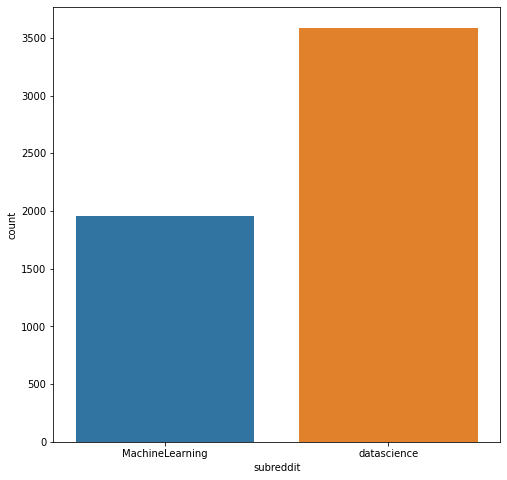

In [17]:
plt.figure(figsize=(8, 8))
sns.countplot(x='subreddit', data=df)

In [18]:
# Undersample the datascience dataset to make it balanced with MachineLearning
ml_df = df[df['subreddit'] == 'MachineLearning']
ds_df = df[df['subreddit'] == 'datascience']
sampled_df = ds_df.sample(n=ml_df.shape[0], random_state=rnd_seed)
df = pd.concat([ml_df, sampled_df])

In [19]:
print('MachineLearning rows are ' + str(df['s_enc'].value_counts()[0]) + ' which is ' + str(round(df['s_enc'].value_counts(normalize = True)[0] * 100,2)) + '% of the dataset')
print('datascience rows are ' + str(df['s_enc'].value_counts()[1]) + ' which is ' + str(round(df['s_enc'].value_counts(normalize = True)[1] * 100,2)) + '% of the dataset')

MachineLearning rows are 1956 which is 50.0% of the dataset
datascience rows are 1956 which is 50.0% of the dataset


<AxesSubplot:xlabel='subreddit', ylabel='count'>

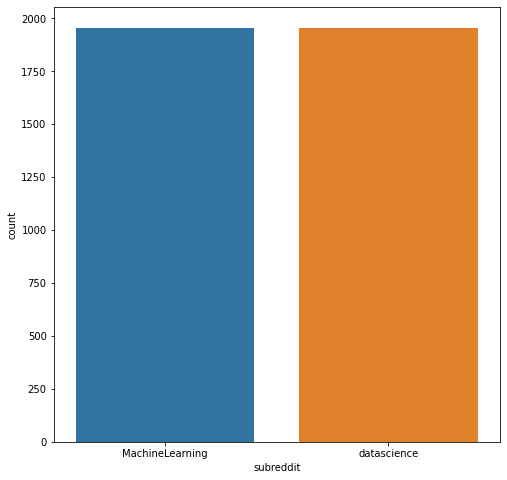

In [20]:
plt.figure(figsize=(8, 8))
sns.countplot(x='subreddit', data=df)

#### The data is now balanced at 50% each.

### 3.3 Pre-processing

In [21]:
# 3.3.1 Renumber the index to remove gaps due to row deletion
df.reset_index(drop=True, inplace=True)

In [22]:
# 3.3.2 Combine the title with the selftext
df['s_txt'] = df['title'] + " " + df['selftext']
# df.drop(['title', 'selftext', 'subreddit'], axis=1, inplace=True)

In [23]:
print("The shape of the dataset is", df.shape)
print("-"*40)
print(df.head())

The shape of the dataset is (3912, 9)
----------------------------------------
        author  created_utc  \
0       JMG518   1634358144   
1  VERITAS9872   1634350909   
2   KryptoPlay   1634347579   
3       JMG518   1634346980   
4   athos45678   1634338421   

                                           full_link      id  \
0  https://www.reddit.com/r/MachineLearning/comme...  q94ral   
1  https://www.reddit.com/r/MachineLearning/comme...  q92wlo   
2  https://www.reddit.com/r/MachineLearning/comme...  q9215u   
3  https://www.reddit.com/r/MachineLearning/comme...  q91vhd   
4  https://www.reddit.com/r/MachineLearning/comme...  q8zhjf   

                                            selftext        subreddit  \
0  Hi guys! I am working on an architecture proje...  MachineLearning   
1  [https://github.com/veritas9872/PyTorch-Univer...  MachineLearning   
2  Hello there,\n\nI am a 33 yr old petroleum eng...  MachineLearning   
3  Hi guys! I am working on an architecture proje...  Mac

### 3.4 Tokenizing the combined text


In [24]:
# 3.4.1 Replace HTML code with blank space, also remove post type text [D],[N],[P],[R] 
for i, text in enumerate(df.s_txt): 
    text_loop = text.replace('&amp;',' ')
    text_loop = text_loop.replace('&gt;',' ') 
    text_loop = text_loop.replace('&lt;',' ') 
    text_loop = text_loop.replace('#x200B;',' ') 
    text_loop = text_loop.replace('nbsp;',' ')
    text_loop = text_loop.replace('[D]',' ')
    text_loop = text_loop.replace('[N]',' ')
    text_loop = text_loop.replace('[P]',' ')
    text_loop = text_loop.replace('[R]',' ')
    df.s_txt.iloc[i] = text_loop.replace('\n',' ').strip()

In [25]:
print(df.head())

        author  created_utc  \
0       JMG518   1634358144   
1  VERITAS9872   1634350909   
2   KryptoPlay   1634347579   
3       JMG518   1634346980   
4   athos45678   1634338421   

                                           full_link      id  \
0  https://www.reddit.com/r/MachineLearning/comme...  q94ral   
1  https://www.reddit.com/r/MachineLearning/comme...  q92wlo   
2  https://www.reddit.com/r/MachineLearning/comme...  q9215u   
3  https://www.reddit.com/r/MachineLearning/comme...  q91vhd   
4  https://www.reddit.com/r/MachineLearning/comme...  q8zhjf   

                                            selftext        subreddit  \
0  Hi guys! I am working on an architecture proje...  MachineLearning   
1  [https://github.com/veritas9872/PyTorch-Univer...  MachineLearning   
2  Hello there,\n\nI am a 33 yr old petroleum eng...  MachineLearning   
3  Hi guys! I am working on an architecture proje...  MachineLearning   
4                                                     MachineLe

In [26]:
# 3.4.2 Use the regular expression tokenizer to create a list of tokens
rt = RegexpTokenizer(r"[\w/\'\"]+") # regex to include words, slash characters for urls, apostrophes
tokens = []  # empty token list

for i in range(len(df.s_txt)):    # Loop over all rows in the s_txt column
    loop_tokens = rt.tokenize(df.s_txt.iloc[i].lower())  # Tokenize lowercase text
    for j, token in enumerate(loop_tokens):
        if re.match(r"\d+[\w]*", token):   # Remove numbers
            loop_tokens[j] = ''
        if re.match(r"//[\w]*", token):    # Remove slash
            loop_tokens[j] = ''
        if ('machinelearning' in token)|('datascience' in token)|('http' in token): # Remove subreddit name or http
            loop_tokens[j] = ''
    tokens.append(loop_tokens)                    # add tokenized string to post_tokens list

### 3.5 Lemmatizing
Using the WordNetLemmatizer, transform each word in the list of tokens.

In [27]:
# Use the WordNetLemmatizer
lm = WordNetLemmatizer()
tokens_lm = []

for post in tokens:                  # Loop through the combined tokens for post
    post_lm = []                     # empty post stems
    for word in post:                # Loop through each words found in post
        word_lm = lm.lemmatize(word) # get lemmatized word
        post_lm.append(word_lm)      # keep the list of lemmatized word
    tokens_lm.append(post_lm)         # add the lemmatized list to the lemma matrix tokens_lm.

In [28]:
posts_lm = []

for post in tokens_lm:
    posts_lm.append(' '.join(post))   # Combine the lemmatized tokens into text
    
print (posts_lm[0:2])

['best github text to image ai code hi guy i am working on an architecture project to design a parking garage and i want to use ai to help in the design process any tip on the most realistic/photo realistic ai code that i can use if anyone can provide link to a specific code that would be incredible thanks everyone', 'pytorch universal docker template build any version of pytorch from source on any version of cuda/cudnn and increase speed x10   com/veritas9872/pytorch universal docker template   com/veritas9872/pytorch universal docker template dear fellow pytorch user i present to you the pytorch universal docker template the docker template for universal pytorch source build a of the time of writing the majority of deep learning research is carried out using the pytorch library however the conda/pip package used to install pytorch are designed for compatibility over performance building pytorch from source thus often increase gpu compute speed dramatically on some benchmark i have ev

In [29]:
# Add the lemmatized text to the DataFrame as new column s_txt_lm.
df = pd.concat([df, pd.DataFrame(posts_lm,columns=['s_txt_lm'])], axis=1)
print(df.columns)

Index(['author', 'created_utc', 'full_link', 'id', 'selftext', 'subreddit',
       'title', 's_enc', 's_txt', 's_txt_lm'],
      dtype='object')


In [30]:
# For checking using excel
df.to_csv (r'../data/interim/df_lm.csv', index = False, header=True)

### 3.6 CountVectorizer and stopwords handling
<br>
&emsp;• Start with NLTK corpus stopwords.<br>
&emsp;• Using the CountVectorizer, visualize the top words.<br>
&emsp;• Determine if additional stopwords need to be removed from the dataset.<br>
&emsp;• Iterate this process to build the list of stopwords during modeling.

In [31]:
# 3.6.1 Take the nltk corpus stopwords as a start
custom = ['com','org','data','science','machine','would','like','ml','wa','use','project','one','time','well','month']
custom = custom + ['also','know','get','work','working','want','could','new','make','need','week','year','using','model']
custom = custom + ['question','ha','problem','help','way','doe','different','good','best','etc','find','think','feel']
custom = custom + ['really','much','anyone','thanks','used','much','lot','company','learning','hi','currently','take','even']
custom = custom + ['since','might','however','tool','reddit','something','example']
stop_list = stopwords.words('english') + custom


In [32]:
print(stop_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [33]:
# 3.6.2 Perform CountVectorizer for MachineLearning and datascience
cv = CountVectorizer(stop_words=stop_list, ngram_range=(1,3))
ml_df = df[df['subreddit'] == 'MachineLearning']
ds_df = df[df['subreddit'] == 'datascience']

ngrams = cv.fit_transform(ml_df['s_txt_lm'])   # matrix of MachineLearning words
count_values = ngrams.toarray().sum(axis=0)    # count frequency of ngrams
vocab = cv.vocabulary_                      # list of ngrams
ml_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'feature'}).iloc[:30,:]

ngrams = cv.fit_transform(ds_df['s_txt_lm'])   # matrix of MachineLearning words
count_values = ngrams.toarray().sum(axis=0)    # count frequency of ngrams
vocab = cv.vocabulary_                      # list of ngrams
ds_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'feature'}).iloc[:30,:]

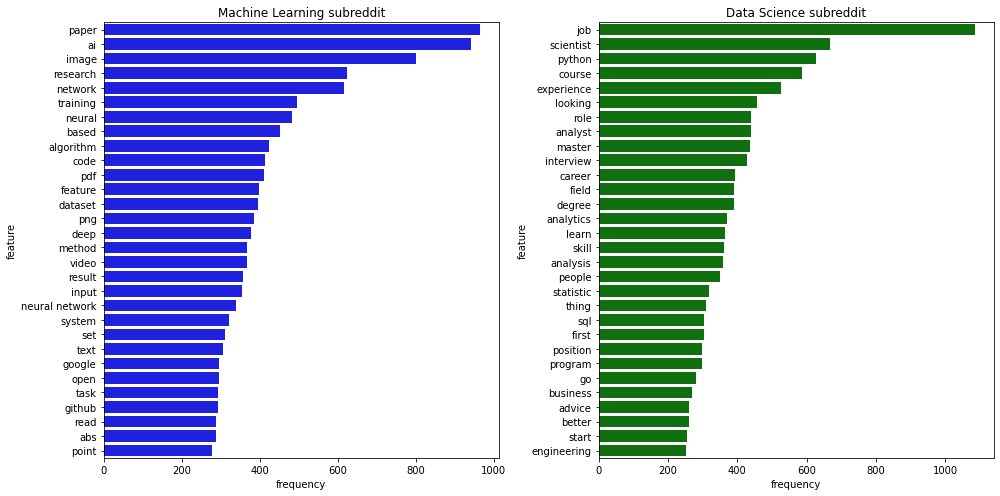

In [34]:
# 3.6.3 Visualize the result
plt.rcParams["figure.figsize"] = [14.00,7]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)
ml_sns = sns.barplot(data=ml_ngram, y='feature', x='frequency', color="blue", ax=axes[0])
ml_sns.set(title='Machine Learning subreddit')
ds_sns = sns.barplot(data=ds_ngram, y="feature", x='frequency', color="green", ax=axes[1])
ds_sns.set(title='Data Science subreddit')
plt.show()

<font color = "red"> Good!

### 3.7 Train Test Split for Modeling
The last step of the pre-processing is to define X and y

In [35]:
df.shape


(3912, 10)

In [36]:
X = df['s_txt_lm']   # The lemmatized text is used as X
y = df['s_enc']      # The encoded subreddit is used as y

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rnd_seed, stratify=y)

In [38]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2934,) (2934,) (978,) (978,)


## 4. Modeling with the Data

### 4.1 Baseline Model

In the section 3.2.4 above the data imbalance has been addressed by downsampling the majority class. Therefore the baseline model for this project is 50% for MachineLearning and 50% for datascience. The calculations are repeated below.

<font color = "red"> There can only be one baseline score. In this case, your baseline accuracy is 50%

In [39]:
# 4.1.1 Determine the baseline model using majority class.
print('MachineLearning rows are ' + str(df['s_enc'].value_counts()[0]) + ' which is ' + str(round(df['s_enc'].value_counts(normalize = True)[0] * 100,2)) + '% of the dataset')
print('datascience rows are ' + str(df['s_enc'].value_counts()[1]) + ' which is ' + str(round(df['s_enc'].value_counts(normalize = True)[1] * 100,2)) + '% of the dataset')

MachineLearning rows are 1956 which is 50.0% of the dataset
datascience rows are 1956 which is 50.0% of the dataset


<AxesSubplot:xlabel='subreddit', ylabel='count'>

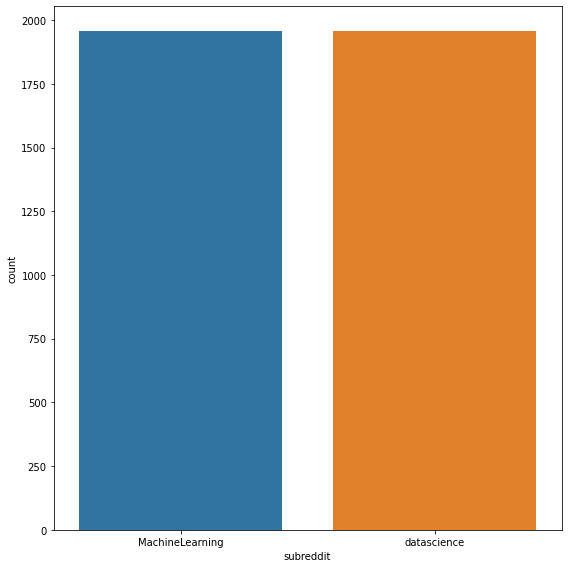

In [40]:
plt.figure(figsize=(8, 8))
sns.countplot(x='subreddit', data=df)

### 4.2 Modeling process 
The two models chosen are RandomForestClassifier (mandatory requirement), and LogisticsRegression.

In [41]:
# DataFrame to collect and display the results

grid_results = pd.DataFrame(columns=['title','best_params','train_accuracy','test_accuracy','tn','fp','fn','tp','model'])
display_labels = ['MachineLearning','datascience']




#### 4.2.1 Hypertuning parameters
The initial results for models using just the default parameters are **overfitted** models

The following results are obtained by iteratively using the GridSearchCV and improving hypertuned parameters. 

Model:  Hypertuned RandomForest 1
Train Accuracy:  0.82
Test Accuracy:  0.8
Is Overfitted?:  2.0% 


Best Params:  {'cv__max_features': 500, 'cv__ngram_range': (1, 2), 'rf__bootstrap': True, 'rf__max_depth': 8, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 100, 'rf__n_jobs': -1} 


                 precision    recall  f1-score   support

MachineLearning       0.76      0.88      0.82       489
    datascience       0.86      0.72      0.78       489

       accuracy                           0.80       978
      macro avg       0.81      0.80      0.80       978
   weighted avg       0.81      0.80      0.80       978
 




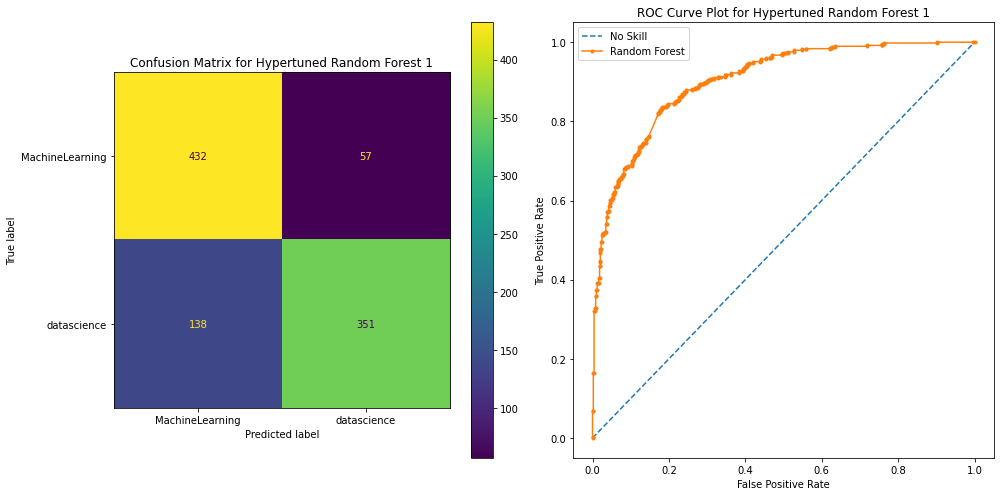

In [42]:
# 4.2.1.1 Perform RandomForestClassifier pipeline

steps_title = 'Hypertuned RandomForest 1'
steps_list_gr_cv = [('cv',CountVectorizer(stop_words=stop_list)),
                    ('rf',RandomForestClassifier(random_state=rnd_seed))]
pipe_params_cv = {"cv__ngram_range":[(1,1),(1,2)], 
                  "cv__max_features": [300, 500],
                  "rf__bootstrap": [True, False], 
                  "rf__max_depth": [2, 3, 5, 8], 
                  "rf__min_samples_leaf": [3, 4, 5],
                  "rf__n_estimators": [100, 200, 300],
                  "rf__n_jobs": [-1]}

#
pipe = Pipeline(steps=steps_list_gr_cv)          # initialize the pipeline
grid = GridSearchCV(pipe, pipe_params_cv, cv=3)  # initialize the GridSearchCV

results = {}

grid.fit(X_train, y_train)
    
print('Model: ',steps_title)
results['title'] = steps_title
results['model'] = grid

print('Train Accuracy: ', round(grid.score(X_train, y_train),2))
results['train_accuracy'] = round(grid.score(X_train, y_train),2)
    
print('Test Accuracy: ', round(grid.score(X_test, y_test),2))
results['test_accuracy'] = round(grid.score(X_test, y_test),2)

print('Is Overfitted?: ',str(round((results['train_accuracy'] - results['test_accuracy'])*100,2))+'%','\n\n')

print('Best Params: ', grid.best_params_ , '\n\n')
results['best_params'] = grid.best_params_

# Display the confusion matrix results showing true/false positive/negative
y_predict = grid.predict(X_test)
y_proba   = grid.predict_proba(X_test)
cm = confusion_matrix(y_test, y_predict)
results['tn'], results['fp'], results['fn'], results['tp'] = cm.ravel() 

print(classification_report(y_test,y_predict,target_names=display_labels),'\n\n')    
grid_results = grid_results.append(results, ignore_index=True) # Keep track of the results
    
# View confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels)
cm_disp.plot(ax=ax1)
ax1.set_title('Confusion Matrix for Hypertuned Random Forest 1')

# The following code snippets are from 
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

# View ROC Curve 
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
ax2.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax2.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
# axis labels
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve Plot for Hypertuned Random Forest 1')
# show the legend
ax2.legend()
# show the plot
plt.show()
print('\n\n')

Model:  Hypertuned LogisticsRegression 2
Train Accuracy:  0.82
Test Accuracy:  0.8
Is Overfitted?:  2.0% 


Best Params:  {'cv__max_df': 0.9, 'cv__max_features': 200, 'cv__min_df': 2, 'logreg__C': 0.01, 'logreg__n_jobs': -1, 'logreg__penalty': 'l2'} 


                 precision    recall  f1-score   support

MachineLearning       0.79      0.81      0.80       489
    datascience       0.81      0.78      0.79       489

       accuracy                           0.80       978
      macro avg       0.80      0.80      0.80       978
   weighted avg       0.80      0.80      0.80       978
 




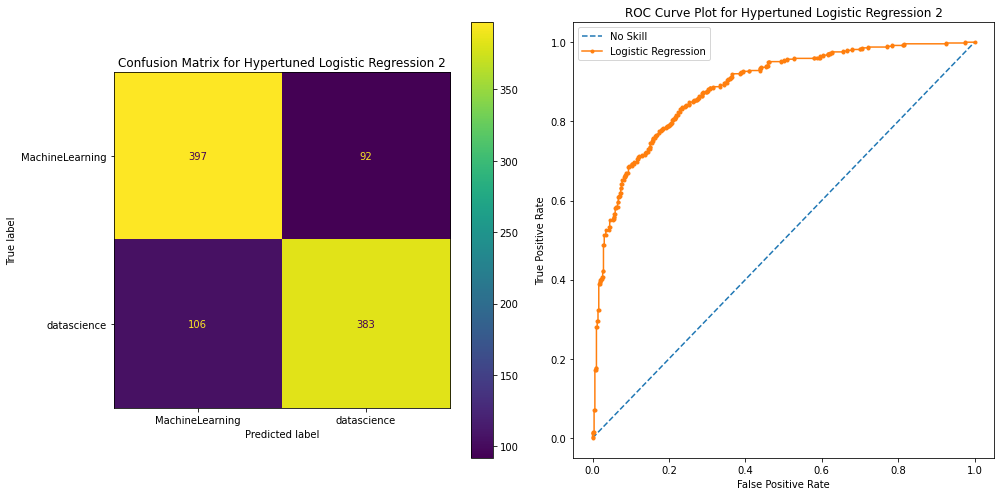

In [43]:
# 4.2.1.2 Perform LogisticsRegresssion pipeline

Best_Params_1 =  {'cv__max_features': 500, 'cv__ngram_range': (1, 1), 
                  'logreg__C': 0.01, 'logreg__n_jobs': -1, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'} 
Best_Params_2 =  {'cv__max_features': 500, 'cv__ngram_range': (1, 1), 
                  'logreg__C': 0.001, 'logreg__l1_ratio': 0.25, 'logreg__n_jobs': -1, 
                  'logreg__penalty': 'l2', 'logreg__solver': 'saga'} 

steps_title = 'Hypertuned LogisticsRegression 2'
steps_list_gr_cv = [('cv',CountVectorizer(stop_words=stop_list)),
                    ('scaler',StandardScaler(with_mean=False)),
                    ('logreg',LogisticRegression())]
pipe_params_cv = {"cv__max_features": [100,200],
                  "cv__min_df": [2,3],
                  "cv__max_df": [.9,.95],
                  "logreg__penalty" : ['l2'],
                  "logreg__C" : [0.01,0.1],
                  "logreg__n_jobs": [-1]}

#
pipe = Pipeline(steps=steps_list_gr_cv)          # initialize the pipeline
grid = GridSearchCV(pipe, pipe_params_cv, cv=3)  # initialize the GridSearchCV

results = {}

grid.fit(X_train, y_train)
clf = grid.best_estimator_.named_steps['logreg']
cvec = grid.best_estimator_.named_steps['cv']
best_model_coef = clf.coef_
    
print('Model: ',steps_title)
results['title'] = steps_title
results['model'] = grid

print('Train Accuracy: ', round(grid.score(X_train, y_train),2))
results['train_accuracy'] = round(grid.score(X_train, y_train),2)
    
print('Test Accuracy: ', round(grid.score(X_test, y_test),2))
results['test_accuracy'] = round(grid.score(X_test, y_test),2)

print('Is Overfitted?: ',str(round((results['train_accuracy'] - results['test_accuracy'])*100,2))+'%','\n\n')

print('Best Params: ', grid.best_params_ , '\n\n')
results['best_params'] = grid.best_params_

# Display the confusion matrix results showing true/false positive/negative
y_predict = grid.predict(X_test)
cm = confusion_matrix(y_test, y_predict)
results['tn'], results['fp'], results['fn'], results['tp'] = cm.ravel() 

print(classification_report(y_test,y_predict,target_names=display_labels),'\n\n')    
grid_results = grid_results.append(results, ignore_index=True) # Keep track of the results
    
# View confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels)
cm_disp.plot(ax=ax1)
ax1.set_title('Confusion Matrix for Hypertuned Logistic Regression 2')

# The following code snippets are from 
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

# View ROC Curve 
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
ax2.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax2.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
# axis labels
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve Plot for Hypertuned Logistic Regression 2')
# show the legend
ax2.legend()
# show the plot
plt.show()
print('\n\n')

In [44]:
# 4.2.3.3 Visualize LogisticsRegresssion coefficients
cvec = grid.best_estimator_.named_steps['cv']
cvec_vocab = cvec.vocabulary_
coef_df = pd.DataFrame(best_model_coef).T
coef_df['ngrams'] = pd.DataFrame(cvec_vocab, index=[0]).columns
coef_df.columns = ['coefficient','ngrams']
coef_df.sort_values(by=['coefficient'], inplace=True, ascending=False)


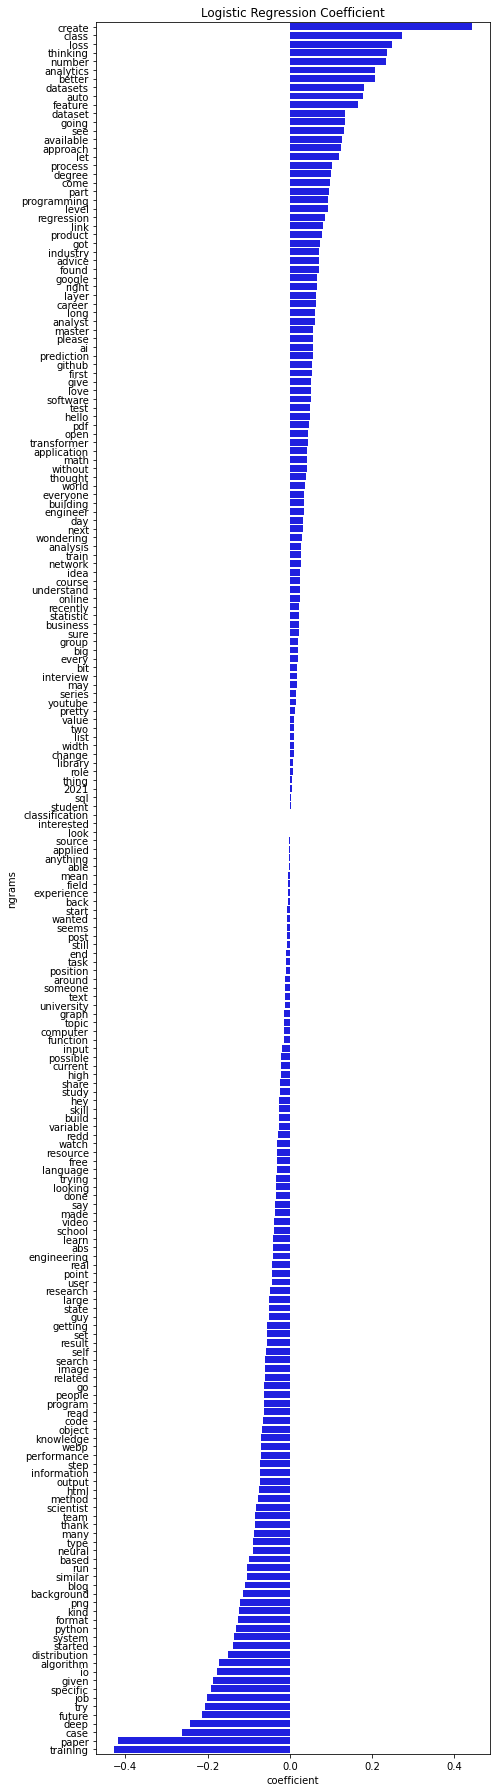

In [45]:
# 3.6.3 Visualize the result
plt.rcParams["figure.figsize"] = [7,25]
plt.rcParams["figure.autolayout"] = True
#f, axes = plt.subplots(1, 2)
ml_sns = sns.barplot(data=coef_df, y='ngrams', x='coefficient', color="blue")
ml_sns.set(title='Logistic Regression Coefficient')
plt.show()

<font color = "red"> How can we interpret the coefficients? Which words are most predictive for the data science subreddit and which words are most predictive for the machine learning subreddit?

## 6. Insights and Conclusion

In this project, the Random Forest Regression model achieved training accuracy of 0.82 and test accuracy of 0.80 for a difference of 2.0%. It can be concluded that the model is not overfitted. 

The Logistic Regression model achieved training accuracy of 0.82 and test accuracy of 0.80 for a difference of 2.0%. This model is also not overfitted.

The Random Forest model performs equally well against the Logistic Regression model in terms of accuracy score, however Random Forest model has a better recall score of 88% for MachineLearning against Logistic Regression model's recall score of 81%.

In conclusion, the Random Forest model outperforms the Logistic Regression model.


## 7. Further Works

Upon inspection of the Logistic Regression coefficients, some additional words are candidates for the stop words list, for example: student, classification, interested, etc. Adding these words to the stop_list may reduce the overfitting further.


